<center><img src='fairfield_university_banner.jpeg'></center>

    
# Project 1: Advanced Preparation of Financial Data 

An IPO is an (Initial Public Offering). It is the first opportunity for a private company to sell stock in their company publicly. Companies do this so they can raise money in their company.

Understanding pricing strategies in the context of the Initial Public Offering (IPO) process has been receiving much attention. Most prior studies have however focused on information sources from post issuance periods, and understanding such strategies from the management’s perspective during the IPO process is still an open research issue. 

Because the company is so new and exclusive, IPOs typically attract a lot of attention when they hit the market. They are typically pretty risky and volatile investments, since the historical pricing data is not there, so it is difficult to predict where the price will go. In finance, there is usually a tradeoff between risk and return. With that said, investors will invest in riskier IPOs hoping for a big potential return.

The data used for this project includes successful U.S. IPOs from more than 600 companies with 22 features to explore the "underpricing" phenomenon most commenly seen in the stock market. In this study, we analyze the inter-relationships between the management’s confidence through the proxy of sentiments expressed in textual contents in the Management’s Discussion & Analysis (MD&A) sections in the prospectus and the pre-/post-IPO valuations. Data was collected from IPO prospectus approved by the Securites Exchange Committee (SEC). 

## Pipeline Overview <a name="introduction"></a>
**The pipeline that we followed in stage 2 is on the left. The pipeline on the right is an alternative for our future work.**

<center><img src = "PIPELINE.jpeg" </img></center>

As shown above, our analysis took the form of standard steps at the beginning and end, with two different pipelines in the middle. In this manner, we can ensure that the early data preperation and final modeling preperation are standardized, but that we also have an opportunity to see if different techniques are more effective such as earlier normalization rather than towards the end of our data prep.

As we expect our target variables to be difficult to predict, we chose to combine the features from both pipelines and allow feature selection to choose the best features. Certain variables may have more predictive power coming from Pipeline A as opposed to Pipeline B. By including both sets we have more options and, hopefully, better predictions.

# Table of contents <a name="tablecontents"></a>
1. [Pipeline Overview](#introduction)
2. [Data Dictionary](#paragraph1)
3. [Identifying Null Values, Descriptive Statistics](#paragraph2)
4. [Encoding and Imputation](#paragraph3)
5. [Feature Engineering](#paragraph4)
6. [Outlier Detection (IQR)](#paragraph5)
7. [Standardization (Min-Max)](#paragraph6)
8. [Normalization](#paragraph7)
9. [Data Merge](#paragrap8)
10. [Correlation Analysis](#paragraph9)
11. [Feature Selection](#paragraph10)
12. [Modeling](#paragraph11)
13. [Results and Reccomendations](#paragraph12)

## Importing Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import seaborn as sns
from scipy.stats import zscore, skew
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from itertools import chain
import xgboost
from sklearn import metrics, model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA

from sklearn.metrics import roc_curve, confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import f1_score
import pickle 

pd.set_option('display.max_columns', 500)

In [3]:
# load raw data
data = pd.read_excel('Competition1_raw_data.xlsx')
# display first 5 rows 
data.head(5)

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3
0,AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674,10,9.5,8.5,11.87,122,1,3.43,0.0290743,40962052,10600000,51.345,470,12719,11560,301,690,62,117,139
1,ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834,8,10,8,7.25,259,0,-1.62,-0.0133516,28869196,2400000,25.936,791,21792,19585,510,1120,71,242,237
2,ACAD,ACADIA PHARMACEUTICALS INC,2834,7,14,12,6.7,90,1,-1.24,0.020715,16845668,5000000,7.378,201,5262,4785,128,325,61,33,60
3,ACHN,ACHILLION PHARMACEUTICALS INC,2834,11.5,16,14,12.39,209,1,-0.91,0.0200231,14848637,4500000,8.526,328,8259,7574,177,509,80,59,110
4,ACLI,AMERICAN COMMERCIAL LINES INC.,4492,21,21,19,56.6,80,1,0.07,-0.0348947,30741716,8250000,632.298,572,14830,13176,336,720,67,149,167


# Data Dictionary <a name="paragraph1"></a>
Back to [Table of Contents](#tablecontents)

<center><img src='data_dictionary.jpeg'></center>

# STAGE 1
## Step 1: Identifying Null Values, Descriptive Statistics <a name="paragraph2"></a>
Back to [Table of Contents](#tablecontents)

### Identifying Null Values 
As given, the data identifies some null values with the '-' symbol. Replacing these with actual null values will allow handling them to be easier.

In [4]:
# Replace the '-' indicator with nulls
for col in data.columns:
    data[col] = data[col].apply(lambda x: np.nan if x == '-' else x)

## Data assumptions

By learning about each column and using common sence we come up with a few rules about our features. 

**IPO Pricing (P Columns)**
- IPO prices cannot contain any zero or negative values 
- Price range higher bound must be higher or equal to the lower bound<br>

**IPO Characteristics (C columns)**
- There can be zero days (C1) between filings, however, no negative values 
- C2 can only be 1 or 0
- Earnings per Share (C3), prior returns (C4), and sales can be zero or negative
- Outstanding and offering shares features (C5, C6) can be zero but not negative

**Textual Characteristics (T colums)**
- Number of sentences (T1), words (T2), and real words (T3) cannot contain any zero or negative values 
- Number of words must be higher than all other T and S features
- It is possible for number of long words (T4) and sentences (T5) to be zero but it cannot be negative
- Number of sentences and must higher than long sentences

**Sentiment characteristics (S columns)**
- Number of positive (S1), negative (S2), and uncertain (S3) words can be zero but cannot be negative or lower than number of words

**Note**
- We we will derive our target features from P columns, meaning, we cannot use in our modeling as they are so called force predictors or "leakers"
- Other features will be calculated after cleaning

Let's write a function to check if such values exist. 

In [5]:
def data_validation(row):  
    '''
    Run initially to identify rows which do not logically make sense.
    Fix the issues, and then rerun until only nulls left
    
    '''
    # If any nulls we know it's off
    ret_val = 0
    if row.isna().any():
        ret_val = 1
    
    # P(H) > P(L)
    #Higher range of price > lower range
    elif row['P(H)'] < row['P(L)']:
        ret_val = 2
        
    elif row['P(1Day)'] == 0:
        ret_val = 3
    
    # T4 < T1
    # Number of long sentences less than number of sentences
    elif row['T4'] > row['T1']:
        ret_val = 4
        
    # T3 < T2
    # Number of words < number of real words
    elif row['T3'] > row['T2']:
        ret_val = 5
    
    elif row['T3'] == 0:
        ret_val = 6
    elif row['T5'] < 0:
        ret_val = 7
        
    # T5 < T2
    # Number of long words < number of total words
    elif row['T5'] > row['T2']:
        ret_val = 8
        
    # T1 < T2
    # Number of words > number of sentences
    elif row['T1'] > row['T2']:
        ret_val = 9
    
    # C2, C3' in [0,1]
    # Defined as only being one of these two
    elif row['C2'] not in [0.0,1.0] and pd.notnull(row['C2']):
        ret_val = 10
    # Outstanding shares less than zero
    elif row['C5'] < 0:
        ret_val = 11
    # offering shares less than zero
    elif row['C6'] < 0:
        ret_val = 12
     
    # Any sentiment words less than zero
    elif row['S1'] < 0:
        ret_val = 13
    elif row['S2'] < 0:
        ret_val = 14
    elif row['S3'] < 0:
        ret_val = 15
        
    # Any sentiment words higher than number of words
    elif row['S1'] >= row['T2']:
        ret_val = 16
    elif row['S2'] >= row['T2']:
        ret_val = 17
    elif row['S3'] >= row['T2']:
        ret_val = 18
    
    return ret_val

We can see that there are 87 rows containing null values. Additionally, a few rows contain logic which does not make sense. We can fix those now, rerun, and check that all rows do not have logical flaws.

In [6]:
# Create a seperate field which indicates that the row, at some point, contained null values which needed to be imputed
data['data_assump'] = data.apply(lambda row: data_validation(row), axis = 1)
data['data_assump'].value_counts()

0     583
1      89
6       3
3       3
5       2
13      1
2       1
Name: data_assump, dtype: int64

In [7]:
data.loc[data['data_assump'] == 2, ['P(H)','P(L)']] = np.nan
data.loc[data['data_assump'] == 3, ['P(1Day)']] = np.nan
data.loc[data['data_assump'] == 4, ['T4','T1']] = np.nan
data.loc[data['data_assump'] == 5, ['T3','T2']] = np.nan
data.loc[data['data_assump'] == 6, ['T3']] = np.nan
data.loc[data['data_assump'] == 7, ['T5']] = np.nan
data.loc[data['T5'] < 0, ["T5"]] = np.nan
data.loc[data['data_assump'] == 13, ['S1']] = np.nan
data['data_assump'] = data.apply(lambda row: data_validation(row), axis = 1)

Now we have 583 non-null values and 99 null values. 

In [8]:
data['data_assump'].value_counts()

0    583
1     99
Name: data_assump, dtype: int64

Now the only issue left is the null values which we can address through imputation. We can see there are 93 of them.

In [9]:
# save changes
import pandas as pd 
# makes it easy so we don't have to run everything again if we take a break
data.to_csv('data_assumptions.csv')
# read it in 
data = pd.read_csv('data_assumptions.csv',index_col=[0])

### Descriptive Statistics 
- Mean/median/std/min/max/count/quartiles
- Missing Records
- I3 imputation and binning
- Outlier Identification
- Address Outliers
- Data Types/Fix data types

The describe method can give a lot of useful information about each of the column values including quartile information, the mean, minimum and maximum values, and the standard deviation.

In [10]:
data.describe()

,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_assump
count,677.000000,671.000000,671.000000,657.000000,660.000000,660.000000,646.000000,660.000000,6.760000e+02,6.760000e+02,610.000000,681.000000,679.000000,676.00000,681.000000,680.000000,680.000000,681.000000,681.000000,682.000000
mean,13.837666,15.504262,13.523264,26.053190,149.728788,0.859091,1.788904,0.007282,4.935776e+07,1.241519e+07,500.459962,465.634361,12796.187040,11424.91716,294.353891,680.220588,68.523529,120.104258,144.759178,0.145161
std,6.053731,6.631436,5.836105,73.381163,152.817467,0.348192,162.666532,0.033318,1.043764e+08,2.512855e+07,1648.337634,175.741647,5413.375602,4781.28552,121.532637,472.540888,39.034361,84.828959,69.276285,0.352522
min,3.000000,3.000000,3.000000,0.000000,10.000000,0.000000,-786.239000,-0.162352,3.693227e+06,5.250000e+05,0.074000,132.000000,527.000000,3003.00000,0.000000,167.000000,5.000000,20.000000,26.000000,0.000000
25%,10.000000,12.750000,11.000000,11.000000,85.000000,1.000000,-0.852500,-0.013927,1.871417e+07,5.000000e+06,37.245750,351.000000,9205.500000,8200.25000,213.000000,462.750000,45.000000,73.000000,100.000000,0.000000
50%,13.500000,15.000000,13.000000,14.880000,107.000000,1.000000,0.010000,0.009125,2.740018e+07,7.398704e+06,103.833000,444.000000,12049.000000,10789.00000,279.000000,624.500000,60.000000,100.000000,134.000000,0.000000
75%,17.000000,17.000000,15.000000,20.500000,155.250000,1.000000,0.470000,0.031571,4.980786e+07,1.200000e+07,331.138000,551.000000,15242.500000,13734.50000,354.000000,795.000000,85.000000,142.000000,173.000000,0.000000
max,85.000000,135.000000,108.000000,1159.200562,2087.000000,1.000000,3864.500000,0.092896,2.138085e+09,4.212336e+08,30683.000000,1750.000000,49056.000000,43952.00000,1058.000000,10277.000000,309.000000,944.000000,883.000000,1.000000


The dataframe above provides several interesting bits of information. To begin with, the min and max fields for each column show that many columns have dramatically different ranges, and therefore cannot be compared in a one-to-one manner as they are on a different scale, in different units. This introduces the need for scaling the data so that it can actually be compared in this manner.

Additionally, the count of each field can be used to explore the columns containing the most null values. The lowest count of 610 implies that the field C7 contains the most null values and will need the most imputation. Due to the clear amount of null values, imputation will need to be explored in depth.

### Missing records

In [11]:
# sum of missing values 
data.isnull().sum()

I1              0
I2              0
I3              8
P(IPO)          5
P(H)           11
P(L)           11
P(1Day)        25
C1             22
C2             22
C3             36
C4             22
C5              6
C6              6
C7             72
T1              1
T2              3
T3              6
T4              1
T5              2
S1              2
S2              1
S3              1
data_assump     0
dtype: int64

From these two lines of code we can see clearly the count and percentage of missing values. Moreover, we confirm that C7 and C3 have the most missing values at 10.6% and 5.3%, respectively. 

In [12]:
# percent of missing values for each column 
(1 - data.count() / len(data))*100

I1              0.000000
I2              0.000000
I3              1.173021
P(IPO)          0.733138
P(H)            1.612903
P(L)            1.612903
P(1Day)         3.665689
C1              3.225806
C2              3.225806
C3              5.278592
C4              3.225806
C5              0.879765
C6              0.879765
C7             10.557185
T1              0.146628
T2              0.439883
T3              0.879765
T4              0.146628
T5              0.293255
S1              0.293255
S2              0.146628
S3              0.146628
data_assump     0.000000
dtype: float64

### Data types

To continue our data exploration we can view the data types present in our data. We expect most to be numeric, either float or ints, with the exception of the first two columns. Notice that I3 and C3 column should be binary. 

In [13]:
data.dtypes

I1              object
I2              object
I3              object
P(IPO)         float64
P(H)           float64
P(L)           float64
P(1Day)        float64
C1             float64
C2             float64
C3             float64
C4             float64
C5             float64
C6             float64
C7             float64
T1             float64
T2             float64
T3             float64
T4             float64
T5             float64
S1             float64
S2             float64
S3             float64
data_assump      int64
dtype: object

Strangely, the data type of I3 appears to be an object. In taking a closer look we can see several rows have string representation of lists of integers rather than a single integer. In checking for those which are string we can view the four objects which need to be updated for the column to be represented in the correct manner.

In [14]:
data[data.I3.apply(lambda x: isinstance(x, str))]

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_assump
0,AATI,ADVANCED ANALOGIC TECHNOLOGIES INC,3674,10.0,9.5,8.5,11.870000,122.0,1.0,3.43,0.029074,40962052.0,10600000.0,51.345,470.0,12719.0,11560.0,301.0,690.0,62.0,117.0,139.0,0
1,ABPI,ACCENTIA BIOPHARMACEUTICALS INC,2834,8.0,10.0,8.0,7.250000,259.0,0.0,-1.62,-0.013352,28869196.0,2400000.0,25.936,791.0,21792.0,19585.0,510.0,1120.0,71.0,242.0,237.0,0
2,ACAD,ACADIA PHARMACEUTICALS INC,2834,7.0,14.0,12.0,6.700000,90.0,1.0,-1.24,0.020715,16845668.0,5000000.0,7.378,201.0,5262.0,4785.0,128.0,325.0,61.0,33.0,60.0,0
3,ACHN,ACHILLION PHARMACEUTICALS INC,2834,11.5,16.0,14.0,12.390000,209.0,1.0,-0.91,0.020023,14848637.0,4500000.0,8.526,328.0,8259.0,7574.0,177.0,509.0,80.0,59.0,110.0,0
4,ACLI,AMERICAN COMMERCIAL LINES INC.,4492,21.0,21.0,19.0,56.599998,80.0,1.0,0.07,-0.034895,30741716.0,8250000.0,632.298,572.0,14830.0,13176.0,336.0,720.0,67.0,149.0,167.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,ZIP,ZIPCAR INC,7514,18.0,16.0,14.0,28.000000,317.0,1.0,-0.37,0.004670,38386565.0,9684109.0,186.101,537.0,13359.0,12303.0,329.0,676.0,87.0,106.0,173.0,0
678,ZLTQ,Zeltiq Aesthetics Inc,3845,13.0,16.0,14.0,15.500000,98.0,1.0,-0.41,0.058689,32758082.0,7000000.0,25.461,496.0,13810.0,12515.0,321.0,784.0,70.0,126.0,173.0,0
679,ZSTN,"ZST Digital Networks, Inc.",3663,8.0,8.5,7.5,7.520000,112.0,0.0,0.60,0.030425,11479826.0,3125000.0,55.431,335.0,9067.0,8066.0,217.0,435.0,38.0,82.0,90.0,0
680,ZUMZ,Zumiez Inc,5600,19.0,17.0,15.0,12.435000,78.0,1.0,0.20,0.032284,13180261.0,3125000.0,117.857,256.0,7087.0,6445.0,182.0,306.0,48.0,38.0,100.0,0


## Step 2: Encoding and Imputation <a name="paragraph3"></a>
Back to [Table of Contents](#tablecontents)

### Encoding

The column I3 refers to the SIC code value associated with a company. As these companies have more than one we can use the following chart to see if any of the rows with more than one SIC code have a natural grouping in their values.

- addresing null values

Industry classifiers: 

| Industry Classifiers | Industry                                                           | 
| :------------------:|:----------------------------------------------------------------:| 
| 100 - 999            | Agriculture, Forestry and Fishing                                  | 
| 1000 - 1499          | Mining                                                             |   
| 1500 - 1799          | Construction                                                       |   
| 2000 - 3999          | Manufacturing                                                      | 
| 4000 - 4999          | Transportation, Communications, Electric, Gas and Sanitary service |   
| 5000 - 5199          | Wholesale Trade                                                    | 
| 5200 - 5999          | Retail Trade                                                       | 
| 6000 - 6799          | Finance, Insurance and Real Estate                                 |   
| 7000 - 8999          | Services                                                           | 
| 9100 - 9729          | Public Administration                                              |   
| 9900 - 9999          | Nonclassifiable                                                    | 

*Source: <addr>https://www.osha.gov/pls/imis/sic_manual.html<addr>*

Both Dolby Laboratories Inc. and RealD Inc. have some semblence of agreement in the SIC codes indicating mostly Manufacturing content. In order to represent this, these two rows will have their I3 column assigned to a value in the Manufacturing range.

The other two rows do not have the same SIC code overlap and will be set as a code in the "Nonclassifiable" range to avoid making assumptions.

In [15]:
# replace with proper SIC code
data.loc[174, ['I3']] = 3500
data.loc[499, ['I3']] = 3500

data.loc[187, ['I3']] = 9999
data.loc[620, ['I3']] = 9999

We believe industry classifiers would be an important feature in determining if the IPO will be underpriced. Therefore, we will impute these values manually. Below are all the Null values for I3. 

In [16]:
data[data['I3'].isnull()]

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_assump
10,ADKU,"ADCARE HEALTH SYSTEMS, INC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,332.0,7534.0,6747.0,169.0,263.0,51.0,65.0,74.0,1
86,BLT,BLOUNT INTERNATIONAL INC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,538.0,12732.0,11126.0,301.0,631.0,94.0,172.0,116.0,1
268,GSL,GLOBAL SIGNAL INC,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48854155.0,7000000.0,NaN,631.0,19479.0,17409.0,451.0,976.0,71.0,252.0,155.0,1
330,KFI,KKR Financial Holdings LLC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,246.0,527.0,9046.0,355.0,10277.0,64.0,48.0,123.0,1
400,NAUH,"National American University Holdings, Inc.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,290.0,8454.0,7137.0,192.0,384.0,45.0,68.0,139.0,1
490,RCH,"CHINA CGAME, INC.",NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50737000.0,737000.0,NaN,322.0,9820.0,8893.0,230.0,410.0,61.0,92.0,91.0,1
597,TRMM,"Access to Money, Inc.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,494.0,12004.0,10226.0,277.0,560.0,46.0,100.0,91.0,1
614,TZOO,TRAVELZOO INC,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,146.0,3600.0,3189.0,88.0,181.0,5.0,26.0,38.0,1


In [17]:
data['I3_Imput'] = data['I3']
#we coudn't find the sic code on this website: https://cage.report/NCAGE/4TQ01
#but we found the naics code and then looked what it the corresponding sic code
# https://siccode.com/naics-code/623110/nursing-care-facilities-skilled-nursing-facilities

data.iloc[10,-1] = 8051
#https://siccode.com/business/blount-international-inc-1
data.iloc[86,-1] = 3199
#https://www.nasdaq.com/market-activity/ipos/overview?dealId=622042-37804
#https://siccode.com/sic-code/4812/radiotelephone-communications
data.iloc[268,-1] = 4412

#https://sec.report/Ticker/KFI
data.iloc[330,-1] = 6199

#https://sec.report/Ticker/NAUH
data.iloc[400,-1] = 8200

#https://sec.report/Ticker/RCH
data.iloc[490,-1] = 8711
#https://sec.report/Ticker/TRMM
data.iloc[597,-1] = 7200
#https://sec.report/Ticker/TZOO
data.iloc[614,-1] = 7373

We can now check again and see if there are any other I3 null values. None, good!

In [18]:
data[data['I3_Imput'].isnull()]

,I1,I2,I3,P(IPO),P(H),P(L),P(1Day),C1,C2,C3,C4,C5,C6,C7,T1,T2,T3,T4,T5,S1,S2,S3,data_assump,I3_Imput


## Encoding
We create a new column based on SIC classifier to better understand our dataset.
- evaluate similarites and differences between different companies based on their sector (classifier)

In [19]:
#bining the l3 col to divisions
def division_func(div) :
    #div = data['I3']
    if div <= 999:
        return 'Agriculture, Forestry and Fishing'
    elif div >= 1000 and div <= 1499:
        return 'Mining'
    elif div >= 1500 and div <= 1799:
        return 'Construction'
    elif div >= 2000 and div <= 3999:
        return 'Manufacturing'
    elif div >= 4000 and div <= 4999:
        return 'Transportation, Communications, Electric, Gas and Sanitary service'
    elif div >= 5000 and div <= 5199:
        return 'Wholesale Trade'
    elif div >= 5200 and div <= 5999:
        return 'Retail Trade'
    elif div >= 6000 and div <= 6799:
        return 'Finance, Insurance and Real Estate'
    elif div >= 7000 and div <= 8999:
        return 'Services'
    elif div >= 9100 and div <= 9729:
        return 'Public Administration'
    elif div >= 9900 and div <= 9999:
        return 'Nonclassifiable'
    else:
        return 'Nonclassifiable'

Manufacturing sector at count 310 is the most represented. Second, Services with 206 companies and Transportation, Communications, Electric, Gas and Sanitary service with 60. 

Manufacturing                                                         310
Services                                                              206
Transportation, Communications, Electric, Gas and Sanitary service     60
Retail Trade                                                           48
Mining                                                                 31
Wholesale Trade                                                        13
Finance, Insurance and Real Estate                                      6
Nonclassifiable                                                         4
Construction                                                            2
Agriculture, Forestry and Fishing                                       2
Name: division, dtype: int64


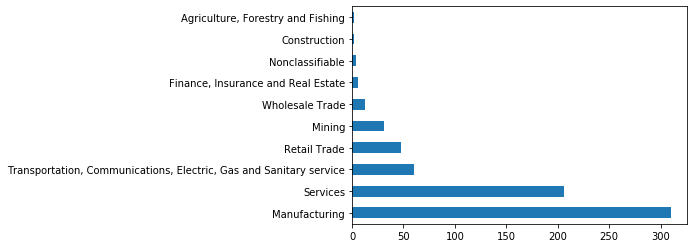

In [20]:
# from object to integers
data['I3_Imput'] = data['I3_Imput'].astype(int)
# apply function
data['division'] = data['I3_Imput'].apply(division_func)
# count of each category
print(data['division'].value_counts())
# plot a bar chart
data['division'].value_counts().plot(kind='barh')

### Encoding the division

We shouldn't feed I3 feature into our machine learning becasue it contains too many values and would create too much noise and mess with our results. 

Encoding division into 3 sectors:
- Manufacturing
- Services
- Other

This is manual one-hot encoding that makes it easier for the machine to read the data. It's creating seperate columns for each category with 1 and 0 values. For instance if the machine encounters 1 that means that the company belongs to that category (e.g. manufacturing). Here is a good tutorial on different ways to handle categorical values: https://www.datacamp.com/community/tutorials/categorical-data.

In [21]:
#encoding the divisions
def division_func_Manufacturing(div) :
    #div = data['I3']
    if div == 'Manufacturing':
        return 1
    else:
        return 0
def division_func_Services(div) :
    #div = data['I3']
    if div == 'Services':
        return 1
    else:
        return 0
    
def division_func_other(div) :
    #div = data['I3']
    if div == 'Agriculture, Forestry and Fishing':
        return 1
    elif div =='Mining':
        return 1
    elif div == 'Construction':
        return 1
    elif div =='Manufacturing':
        return 0
    elif div =='Transportation, Communications, Electric, Gas and Sanitary service':
        return 1
    elif div =='Wholesale Trade':
        return 1
    elif div =='Retail Trade':
        return 1
    elif div =='Finance, Insurance and Real Estate':
        return 1
    elif div =='Services':
        return 0
    elif div =='Public Administration':
        return 1
    elif div =='Nonclassifiable':
        return 1

Create a new column for these 3 categories and apply the appropriate functions we created. 

In [22]:
data['div_manufacturing'] = data['division'].apply(division_func_Manufacturing )
div1= data['div_manufacturing'].value_counts().to_frame('count').reset_index().rename({'index' :'div_manufacturing'}, axis='columns')
  

data['div_other'] = data['division'].apply(division_func_other)
div2 = data['div_other'].value_counts().to_frame('count').reset_index().rename({'index' :'div_other'}, axis='columns')
       

data['div_services'] = data['division'].apply(division_func_Services )
div3 = data['div_services'].value_counts().to_frame('count').reset_index().rename({'index' :'div_services'}, axis='columns')
pd.concat([div1 , div2, div3] , axis =1)

,div_manufacturing,count,div_other,count,div_services,count
0,0,372,0,516,0,476
1,1,310,1,166,1,206


We see that our sample is quite unbalanced which is not great. But there is a way to balance it. Again 1 means how many times the company appears in the dataset.

In [23]:
import pandas as pd
data.to_csv('after_binning.csv')
data = pd.read_csv('after_binning.csv', index_col=[0])

## Imputation 
Unfortuantly, most data is not without missing values. As a result, imputation must be performed in order to replace those missing values with actual values. These missing values are typically seen as NaN in the dataset. It is important to remember that with imputation we will be introducing an error to our data. 

Imputation options: 
1. Forward fill, backward fill 
2. Regression
3. Implied imputation (Moving Average, stdev...) 
3. Decision trees, Naive Baise... 
4. Mean 
5. Median (used)
6. Mode 
7. Clustering
8. Manual filling with online research
9. Dropping (discouraged, rule of thumb if you are missing 30-50% of the data)

As a design decision, median is usually a preffered method of imputing missing values.  Median is generally considered to be the best representative of where the center of the data is. 
- Forward and backward fill are not viable alternatives becasue we would fill NA's based on other companies
- Clustering would be a viable alternative we would like to explore in the future
- In our case we must drop NA values for P columns as we use them to calculate the target features 

Documentation for fillna methods can be found [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

In [24]:
# impute with median 
data['S1_impute'] = data['S1'].fillna(data['S1'].median())
data['T2_impute'] = data['T2'].fillna(data['T2'].median())
data['T5_impute'] = data['T5'].fillna(data['T5'].median())
data['C3_impute'] = data['C3'].fillna(data['C3'].median())
data['C7_impute'] = data['C7'].fillna(data['C7'].median())
data['T1_impute'] = data['T1'].fillna(data['T1'].median())
data['T3_impute'] = data['T3'].fillna(data['T3'].median())
data['T4_impute'] = data['T4'].fillna(data['T4'].median())

# drop NA values for P columns
data.dropna(subset=['P(IPO)', 'P(H)', 'P(L)', 'P(1Day)'], inplace=True)

# reset index to show the correct one, drop the old one
data = data.reset_index().drop('index', axis=1)

We now believe that there is no more null values. We do have null values in our original columns but that's fine. 

In [25]:
data.isnull().sum()

I1                    0
I2                    0
I3                    0
P(IPO)                0
P(H)                  0
P(L)                  0
P(1Day)               0
C1                    0
C2                    0
C3                   24
C4                    0
C5                    0
C6                    0
C7                   60
T1                    0
T2                    2
T3                    5
T4                    0
T5                    1
S1                    1
S2                    0
S3                    0
data_assump           0
I3_Imput              0
division              0
div_manufacturing     0
div_other             0
div_services          0
S1_impute             0
T2_impute             0
T5_impute             0
C3_impute             0
C7_impute             0
T1_impute             0
T3_impute             0
T4_impute             0
dtype: int64

It is important to keep the original values. They contain null values there we will select a subset of data here where there are no null values.

In [26]:
#import pandas as pd
data.to_csv('clean_data.csv')
data = pd.read_csv('clean_data.csv', index_col=[0])

Innitially we had 684 rows and 22 columns/features. After imputation and encoding we now have 565 rows and 37 columns in the dataframe. 

In [27]:
# shape of dataframe
data.shape

(656, 36)

# Step 3: Feature Engeneering (Calculation) <a name="paragraph4"></a>
Back to [Table of Contents](#tablecontents)

Now its time to calculate our target and control featuers. Notice T and S columns are counts of words and sentences for which we have to calculate ratios. Numbers matter. When we reach standardization it will assign weights to the value based on its representation in the feature. Meaning words with higher count will receive a higher weight than they are supposed to.

**Note:** 
- As we use P columns to calculate target and control features we cannot use them in the feature selection
- Likewise we cannot use C6` prime column for Y1 as the calculation is too similar 
- I1 and I2 will not be used in the model as we did not find them useful 

Here a helful link on [feature engineering](https://towardsdatascience.com/feature-engineering-in-python-part-i-the-most-powerful-way-of-dealing-with-data-8e2447e7c69e).

### Formulas 
<center><img src='formulas.jpeg' </img></center>

### Calculation

In [28]:
# Middle price between higher and lower point of IPO evaluation for which IPO is priced at 
# its purpuse is to create target variables (classification)
data['P(mid)'] = (data['P(H)'] + data['P(L)'])/2 

# replace Y1 and change dtype to binary
data['Y1'] = np.where((data['P(IPO)'] < data['P(mid)']), 1, 0)
data['Y2'] = np.where((data['P(IPO)'] > data['P(1Day)']), 1, 0)

# another way to impute is with a function especially if you will reuse it 
# if value is bigger than zero return 1 else 0 
def c3_prime(c3_impute):
    if c3_impute > 0:
        return (1)
    else:
        return (0)

# Control variables calculation
# Apply the function above and create an new column 
data['C3`'] = data['C3_impute'].apply(c3_prime)

# calculate share overhang C5`
data['C5`'] = data['C5']/data['C6']

# calculate up revision C6`
data['C6`'] = ((data['P(IPO)'] - data['P(mid)']) / data['P(mid)']) * 1
data['C6`'] = np.where((data['P(IPO)'] <= data['P(mid)']),0,data['C6`'])

### Correcting the Data Type
Converting data into the correct data type per dictionary specifications. Now all data has a correct type.

In [29]:
# convert these columns to int
data[['C2','Y1','Y2','C3`']] = data[['C2','Y1','Y2','C3`']].astype(int)
# show data type info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 656 entries, 0 to 655
Data columns (total 42 columns):
I1                   656 non-null object
I2                   656 non-null object
I3                   656 non-null float64
P(IPO)               656 non-null float64
P(H)                 656 non-null float64
P(L)                 656 non-null float64
P(1Day)              656 non-null float64
C1                   656 non-null float64
C2                   656 non-null int64
C3                   632 non-null float64
C4                   656 non-null float64
C5                   656 non-null float64
C6                   656 non-null float64
C7                   596 non-null float64
T1                   656 non-null float64
T2                   654 non-null float64
T3                   651 non-null float64
T4                   656 non-null float64
T5                   655 non-null float64
S1                   655 non-null float64
S2                   656 non-null float64
S3               

## Feature Engineering (Ratios)
S and T columns are counts of words and sentences. It is usually better to have a balanced training set, since otherwise the decision boundary is gonna give too much space to the bigger class and you are going to misclassify too much the small class. This is usually bad. Think of cancer detection where the smaller class is the most costly, namely having a tumor.

Moreover, this is useful for generating new features not only for counts. 

In [30]:
# Ratios for T columns 
data["words_per_sentence"] = (data["T2_impute"]/data["T1_impute"]).astype(float)
data["real_word_per_word"] = (data["T3_impute"]/data["T2_impute"]).astype(float)
data["non_real_word_per_word"] = ((data["T2_impute"] - data['T3_impute'])/data['T2_impute']).astype(float)
data["short_sentences"] = (data["T1_impute"]/data["T4_impute"]).astype(float)
data['short_sentences_per_sent'] = (data['short_sentences'] / data['T1_impute']).astype(float)
data['long_sentences_per_sent'] = (data['T4_impute'] / data['T1_impute']).astype(float)
data['long_words_per_sent'] = (data['T5_impute'] / data['T2_impute']).astype(float)

In [31]:
# Ratios for S columns 
data['pos_words_percent'] = (data['S1_impute'] / (data['S1_impute'] + data['S2'] + data['S3'])).astype(float)
data['neg_words_percent'] =(data['S2'] / (data['S1_impute'] + data['S2'] + data['S3'])).astype(float)
data['uncertain_words_percent'] = (data['S3'] / (data['S1_impute'] + data['S2'] + data['S3'])).astype(float)

In [32]:
# mix and match T and S columns
data['words_per_pos_words'] = (data['T2_impute']/data['S1_impute']).astype(float)
data['words_per_neg_words'] = (data['T2_impute']/data['S2']).astype(float)
data['words_per_uncertain'] = (data['T2_impute']/data['S3']).astype(float)

In [33]:
# Ratios for C columns 
data['total_shares'] = data['C5'] + data['C6']
data['sales_per_share'] = data['C7_impute']/data['total_shares']
data['outstanding_share_per'] = data['C5']/data['total_shares']
data['offering_share_per'] = data['C6']/data['total_shares']

In [34]:
# save data
import pandas as pd
data.to_csv('ratios_done.csv')
data = pd.read_csv('ratios_done.csv', index_col=[0])

In [35]:
data.columns

Index(['I1', 'I2', 'I3', 'P(IPO)', 'P(H)', 'P(L)', 'P(1Day)', 'C1', 'C2', 'C3',
       'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'S1', 'S2', 'S3',
       'data_assump', 'I3_Imput', 'division', 'div_manufacturing', 'div_other',
       'div_services', 'S1_impute', 'T2_impute', 'T5_impute', 'C3_impute',
       'C7_impute', 'T1_impute', 'T3_impute', 'T4_impute', 'P(mid)', 'Y1',
       'Y2', 'C3`', 'C5`', 'C6`', 'words_per_sentence', 'real_word_per_word',
       'non_real_word_per_word', 'short_sentences', 'short_sentences_per_sent',
       'long_sentences_per_sent', 'long_words_per_sent', 'pos_words_percent',
       'neg_words_percent', 'uncertain_words_percent', 'words_per_pos_words',
       'words_per_neg_words', 'words_per_uncertain', 'total_shares',
       'sales_per_share', 'outstanding_share_per', 'offering_share_per'],
      dtype='object')

In [36]:
# select data for preprocessing 
data_clean = data[['C1', 'C4', 'C5', 'C6',
        'S2', 'S3', 'S1_impute',
       'T2_impute', 'T5_impute', 'C3_impute', 'C7_impute', 'T1_impute',
       'T3_impute', 'T4_impute', 'C5`', 'C6`',
       'words_per_sentence', 'real_word_per_word', 'non_real_word_per_word',
       'short_sentences', 'short_sentences_per_sent',
       'long_sentences_per_sent', 'long_words_per_sent', 'pos_words_percent',
       'neg_words_percent', 'uncertain_words_percent', 'words_per_pos_words',
       'words_per_neg_words', 'words_per_uncertain', 'total_shares',
       'sales_per_share', 'outstanding_share_per', 'offering_share_per']]
data_clean.to_csv('continous_clean.csv')

This completes the first stage of the pipeline. From here we took 2 approaches for preprocessing data. 

# STAGE 2

<center><img src= 'stage_2.jpeg'</img></center>

## Pipeline A
Pipeline A, first detects outliers as points further than 1.5 IQR. Points identified as further than this range had their values altered to sit at the end of the 1.5 IQR range.
The data was then standardized with a min-max scaler to place all values between 0 and 1. Following this, the data was normalized.

## Pipeline B
Pipeline B normalizes the data as its first step. Following this, Z-Scores standardization and outlier detection using three standard deviations from the mean had their values altered to the nearest edge of the three standard deviation range.

# Pipeline A
## Step 1: Outlier Detection - IQR method <a name="paragraph5"></a>
Back to [Table of Contents](#tablecontents)

Machine learning algorithms are very sensitive to the range and distribution of attribute values. Data outliers can spoil and mislead the training process resulting in longer training times, less accurate models and ultimately poorer results. There are many different statistical ways to identify outliers for example, box plots, scatter plots (only for continous dtype), z-score, IQR etc. 

The **interquartile range (IQR)**, also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1. The IQR does not assume normal distribution, therefore, it is used here before the normalization step (z-score assumes normality therefore normalization is required first). 

Other methods:
- Binning 
- Replace outliers with the lower and upper bound
- Drop outliers
- Ignore

Visit [here](https://medium.com/@prashant.nair2050/hands-on-outlier-detection-and-treatment-in-python-using-1-5-iqr-rule-f9ff1961a414) for more information.

### Outlier Detection
We will calculate the IQR (Q3 - Q1) to see how many values are outside the IQR range. 

**Note:** Data transformation is only applied on continous and not original data type. 

In [37]:
# Calculate IQR range
def iqr_calc(df):
    Q1 = df.quantile(0.25) # Q1 range
    Q3 = df.quantile(0.75) # Q3 range
    IQR = Q3 - Q1 # IQR range
    outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
    return outliers

The most number of outliers reside in the Earnings per Share column (C3_impute) - 114, then C7 - 88 etc... Company sizes, revenues etc. vary so, naturaly there would be outliers. However, many machine learning algorithms are sensitive to the range and distribution of attribute values in the input data. Outliers in input data can skew and mislead the training process of machine learning algorithms resulting in longer training times, less accurate models and ultimately poorer results.

In [38]:
# display data if data is smaller than Q1 range or bigger than Q3 range
iqr_calc(data_clean)

C1                           66
C4                            8
C5                           53
C6                           72
S2                           37
S3                           25
S1_impute                    22
T2_impute                    20
T5_impute                    19
C3_impute                   114
C7_impute                    88
T1_impute                    15
T3_impute                    19
T4_impute                    18
C5`                          34
C6`                          43
words_per_sentence           18
real_word_per_word           30
non_real_word_per_word       30
short_sentences              13
short_sentences_per_sent     31
long_sentences_per_sent       6
long_words_per_sent          11
pos_words_percent            13
neg_words_percent             6
uncertain_words_percent      12
words_per_pos_words          19
words_per_neg_words          12
words_per_uncertain          15
total_shares                 59
sales_per_share              71
outstand

## IQR Outlier Treatment

We will use IQR lower and upper bound. Meaning values that are lower than 0.25 and bigger than 0.75 range will be replaced by its bound.

In [39]:
# function that loops over pandas series and replaces outliers by its bounds accordingly 
def outlier_treatment(df):
    for col in df.columns:
        q1,q3 = np.percentile(df[col] , [25,75])
        iqr = q3 - q1
        lower_range = q1 - (1.5 * iqr)
        upper_range = q3 + (1.5 * iqr)
        df[col] = np.where((df[col] < lower_range), lower_range, df[col])
        df[col] = np.where((df[col] > upper_range), upper_range, df[col])
    return df

In [40]:
# apply the IQR function the the dataframe
# make a copy
continous_data_iqr = data_clean.copy()
continous_data_iqr = outlier_treatment(continous_data_iqr) # apply function
continous_data_iqr.columns = continous_data_iqr.columns + '_iqr' # add a _iqr to each col
# now we have 66 columns 
continous_data_iqr.shape

(656, 33)

We now have a merged dataframe of clean continous values with and without outliers. 

In [41]:
iqr_calc(continous_data_iqr).head(3)

C1_iqr    0
C4_iqr    0
C5_iqr    0
dtype: int64

Function inspired from the following post. <br>
Source: https://medium.com/@prashant.nair2050/hands-on-outlier-detection-and-treatment-in-python-using-1-5-iqr-rule-f9ff1961a414

### Check if there is any outliers left 
Defensive coding is a must in data analytics. You don't want to figure out later on that something did not work as it was supposed to. As we see here we no longer have any outliers. 

In [42]:
continous_data_iqr.describe()

,C1_iqr,C4_iqr,C5_iqr,C6_iqr,S2_iqr,S3_iqr,S1_impute_iqr,T2_impute_iqr,T5_impute_iqr,C3_impute_iqr,C7_impute_iqr,T1_impute_iqr,T3_impute_iqr,T4_impute_iqr,C5`_iqr,C6`_iqr,words_per_sentence_iqr,real_word_per_word_iqr,non_real_word_per_word_iqr,short_sentences_iqr,short_sentences_per_sent_iqr,long_sentences_per_sent_iqr,long_words_per_sent_iqr,pos_words_percent_iqr,neg_words_percent_iqr,uncertain_words_percent_iqr,words_per_pos_words_iqr,words_per_neg_words_iqr,words_per_uncertain_iqr,total_shares_iqr,sales_per_share_iqr,outstanding_share_per_iqr,offering_share_per_iqr
count,656.000000,656.000000,6.560000e+02,6.560000e+02,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,6.560000e+02,6.560000e+02,656.000000,656.000000
mean,126.832698,0.007453,3.777593e+07,9.580074e+06,113.548780,142.775343,66.522866,12696.176829,660.139482,-0.259894,210.605332,462.719512,11334.151296,292.613186,3.999791,0.043612,27.248749,0.894257,0.105743,1.609364,0.003882,0.628584,0.052196,0.205544,0.346603,0.446972,206.552129,121.452922,91.445744,4.810544e+07,4.933623e-06,0.781715,0.218285
std,64.047060,0.032803,2.642485e+07,5.989078e+06,56.130361,55.372068,30.858348,4670.396441,253.722215,1.241218,232.576577,152.034399,4163.045192,108.808359,1.639106,0.064180,3.282004,0.021814,0.021814,0.181328,0.001498,0.069807,0.006812,0.053878,0.074547,0.070874,63.533043,36.495112,20.511409,3.269051e+07,5.010641e-06,0.070661,0.070661
min,10.000000,-0.082174,3.693227e+06,8.000000e+05,20.000000,40.000000,9.000000,3271.000000,167.000000,-2.591250,0.074000,132.000000,3003.000000,2.125000,0.283223,0.000000,18.825562,0.843598,0.050717,1.210145,0.000945,0.440024,0.034043,0.069307,0.146878,0.260385,77.887500,40.642361,37.990674,5.750000e+06,2.678006e-09,0.606232,0.037102
25%,85.000000,-0.013927,1.885256e+07,5.145682e+06,74.000000,100.000000,45.000000,9284.000000,464.750000,-0.795000,41.458000,356.750000,8310.000000,214.000000,2.845893,0.000000,24.951161,0.883230,0.090349,1.481858,0.002815,0.580907,0.047544,0.168986,0.293497,0.399491,159.837004,95.211299,77.831862,2.500120e+07,1.188323e-06,0.739982,0.170851
50%,107.000000,0.009283,2.745438e+07,7.500000e+06,101.500000,135.000000,60.000000,12128.000000,627.000000,0.010000,103.833000,447.000000,10811.000000,280.000000,3.727338,0.000000,26.791181,0.897133,0.102867,1.589879,0.003571,0.628979,0.051943,0.201476,0.347219,0.447330,198.379469,116.960010,88.457748,3.499346e+07,2.870578e-06,0.788464,0.211536
75%,155.250000,0.031571,5.003986e+07,1.200000e+07,144.000000,174.250000,85.000000,15275.000000,801.250000,0.402500,300.764000,553.250000,13781.500000,355.250000,4.853040,0.076923,29.034893,0.909651,0.116770,1.721447,0.004673,0.674828,0.056544,0.239457,0.391244,0.492228,242.076471,143.769819,104.392655,6.377870e+07,6.944209e-06,0.829149,0.260018
max,260.625000,0.092896,9.682082e+07,2.228148e+07,249.000000,285.625000,145.000000,24261.500000,1306.000000,2.198750,689.723000,848.000000,21988.750000,567.125000,7.863761,0.192308,35.160492,0.949283,0.156402,2.080830,0.007460,0.815711,0.070045,0.345164,0.537863,0.631334,365.435670,216.607600,144.233843,1.219449e+08,1.557804e-05,0.962898,0.393768


We believe there is no more outliers left. Moreover, from the counts we see that we have all data. 

In [43]:
# save 
import pandas as pd 
continous_data_iqr.to_csv('after_iqr.csv') # save
continous_data_iqr = pd.read_csv('after_iqr.csv', index_col=[0]) # read in
min_max = continous_data_iqr.copy() # copy 

# Step 2: Standardization (Min-Max) <a name="paragraph6"></a>
Back to [Table of Contents](#tablecontents)

Normalization and standardization are often misused terms. **Normalization** is the process of bringing or returning something to a normal condition or state. **Standardization** or scale generally means to change the range of the values. 

For **standardization,** the shape of the distribution doesn’t change (unlike normalization). Think about how a scale model of a building has the same proportions as the original, just smaller. That’s why we say it is drawn to scale. The range is often set at 0 to 1. Standardize generally means changing the values so that the distribution standard deviation from the mean equals one. It outputs something very close to a normal distribution. Scaling is often implied. Many machine learning algorithms perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed. 

In [44]:
# import min-max scaler
from sklearn.preprocessing import MinMaxScaler
# select only values of the df 
x = min_max.values
scaler = MinMaxScaler() # innitialize function
x_scaled = scaler.fit_transform(x) # fit the scaler to the model 
min_max_df = pd.DataFrame(x_scaled) # transform to df 
min_max_df.columns = min_max.columns + '_min_max' # add min_max to cols

Data is now standardized

In [45]:
# check if standardized 
min_max_df.describe()

,C1_iqr_min_max,C4_iqr_min_max,C5_iqr_min_max,C6_iqr_min_max,S2_iqr_min_max,S3_iqr_min_max,S1_impute_iqr_min_max,T2_impute_iqr_min_max,T5_impute_iqr_min_max,C3_impute_iqr_min_max,C7_impute_iqr_min_max,T1_impute_iqr_min_max,T3_impute_iqr_min_max,T4_impute_iqr_min_max,C5`_iqr_min_max,C6`_iqr_min_max,words_per_sentence_iqr_min_max,real_word_per_word_iqr_min_max,non_real_word_per_word_iqr_min_max,short_sentences_iqr_min_max,short_sentences_per_sent_iqr_min_max,long_sentences_per_sent_iqr_min_max,long_words_per_sent_iqr_min_max,pos_words_percent_iqr_min_max,neg_words_percent_iqr_min_max,uncertain_words_percent_iqr_min_max,words_per_pos_words_iqr_min_max,words_per_neg_words_iqr_min_max,words_per_uncertain_iqr_min_max,total_shares_iqr_min_max,sales_per_share_iqr_min_max,outstanding_share_per_iqr_min_max,offering_share_per_iqr_min_max
count,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000
mean,0.466165,0.511951,0.365979,0.408728,0.408510,0.418424,0.422962,0.449021,0.432958,0.486713,0.305273,0.461899,0.438811,0.514138,0.490278,0.226780,0.515655,0.479340,0.520660,0.458511,0.450868,0.501907,0.504232,0.493870,0.510824,0.503000,0.447454,0.459242,0.503139,0.364521,0.316586,0.492008,0.507992
std,0.255549,0.187369,0.283749,0.278802,0.245111,0.225433,0.226900,0.222500,0.222759,0.259127,0.337239,0.212339,0.219272,0.192581,0.216226,0.333739,0.200919,0.206407,0.206407,0.208259,0.229993,0.185813,0.189201,0.195312,0.190665,0.191060,0.220947,0.207400,0.193061,0.281342,0.321703,0.198114,0.198114
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.299252,0.389826,0.162780,0.202299,0.235808,0.244275,0.264706,0.286463,0.261414,0.375000,0.060007,0.313897,0.279525,0.375000,0.338059,0.000000,0.375000,0.375000,0.375000,0.312068,0.287005,0.375000,0.375000,0.361343,0.375000,0.375000,0.284994,0.310112,0.375000,0.165680,0.076123,0.375000,0.375000
50%,0.387032,0.522403,0.255146,0.311897,0.355895,0.386768,0.375000,0.421953,0.403863,0.543058,0.150452,0.439944,0.411256,0.491814,0.454337,0.000000,0.487643,0.506555,0.493445,0.436133,0.403128,0.502958,0.497180,0.479122,0.512401,0.503965,0.419032,0.433709,0.475015,0.251676,0.184131,0.510932,0.489068
75%,0.579551,0.649710,0.497668,0.521379,0.541485,0.546565,0.558824,0.571878,0.556848,0.625000,0.436004,0.588338,0.567715,0.625000,0.602835,0.400000,0.625000,0.625000,0.625000,0.587241,0.572203,0.625000,0.625000,0.616806,0.625000,0.625000,0.570996,0.586067,0.625000,0.499408,0.445674,0.625000,0.625000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As we see the minimum and maximum value for columns is 0 and 1, respectively. 

In [46]:
# import 
import pandas as pd
#min_max_df.to_csv('after_min_max.csv') # save
clean_iqr_min_max = pd.read_csv('after_min_max.csv', index_col=[0]) # read in 
normalization_df = clean_iqr_min_max.copy() # copy

## STEP 3: Normalization <a name="paragraph7"></a>
Back to [Table of Contents](#tablecontents)

#### Normality test
As we see it's quite simple to plot a histogram. As we said here is where the "labor" begins. The following columns below need to be normalized. The decision is based if .skew returns a higher value than 0.5 or smaller than -0.5. If the data is bigger than 0 that means the skew is to the right and vice versa. Different methods are used based on the directions of the skew. The following columns will be normalized using a manual approach (transformation functions). For information on transformation functions check [HERE](https://fmwww.bc.edu/repec/bocode/t/transint.html).

- Right skew: C1, C5, C6, S2, S3, S1_impute, T2impute, T5_impute, C7_impute, T3_impute, T4_impute, C5`, C6`
,short_sentences, short_sentences_per_sent, total_shares, sales_per_share, words_per_pos_words<br>
- Left skew: real_word_per_word

We commented out the histograms to save space. Feel free to remove them. The function printed out the skew to identify not normal distributions.

In [47]:
normalization_df_cols = normalization_df.columns
for col in normalization_df_cols:
    if normalization_df[col].skew() > 0.5:
        print('Right skew: ',col,normalization_df[col].skew())
        #normalization_df[col].hist()
        #plt.title(col)
        #plt.show()
    elif normalization_df[col].skew() < -0.5:
        print('Left skew: ',col,normalization_df[col].skew())
        #normalization_df[col].hist()
        #plt.title(col)
        #plt.show()
    else:
        ''

Right skew:  C1_iqr_min_max 0.8339361967316401
Right skew:  C5_iqr_min_max 1.0867933448939826
Right skew:  C6_iqr_min_max 1.0459241757043918
Right skew:  S2_iqr_min_max 0.8607891574287595
Right skew:  S3_iqr_min_max 0.7475369245210702
Right skew:  S1_impute_iqr_min_max 0.7326931660401989
Right skew:  T2_impute_iqr_min_max 0.5713749037260527
Right skew:  T5_impute_iqr_min_max 0.686267167141194
Right skew:  C7_impute_iqr_min_max 1.1782164849226924
Right skew:  T3_impute_iqr_min_max 0.6029240561482829
Right skew:  T4_impute_iqr_min_max 0.5017373409998523
Right skew:  C5`_iqr_min_max 0.720839145769024
Right skew:  C6`_iqr_min_max 1.200275730002465
Left skew:  real_word_per_word_iqr_min_max -0.5961158037273653
Right skew:  non_real_word_per_word_iqr_min_max 0.596115803727371
Right skew:  short_sentences_iqr_min_max 0.5429814126191647
Right skew:  short_sentences_per_sent_iqr_min_max 0.8425422277282046
Right skew:  words_per_pos_words_iqr_min_max 0.601918963600124
Right skew:  total_shares_i

# Normalization
- Normalize using transformation functions 

- Right skew: C1, C5, C6, S2, S3, S1_impute, T2impute, T5_impute, C7_impute, T3_impute, T4_impute, C5`, C6`
,short_sentences, short_sentences_per_sent, total_shares, sales_per_share, words_per_pos_words<br>
- Left skew: real_word_per_word

[Transformation Functions Resource](https://towardsdatascience.com/transforming-skewed-data-73da4c2d0d16)

In [48]:
# right skew 
normalization_df['C1_norm'] = np.sqrt(normalization_df['C1_iqr_min_max'])
normalization_df['C5_norm'] = np.sqrt(np.sqrt(normalization_df['C5_iqr_min_max']))
normalization_df['C6_norm'] = np.sqrt(normalization_df['C6_iqr_min_max'])
normalization_df['S2_norm'] = np.sqrt(normalization_df['S2_iqr_min_max'])
normalization_df['S3_norm'] = np.sqrt(normalization_df['S3_iqr_min_max'])
normalization_df['S1_norm'] = np.sqrt(normalization_df['S1_impute_iqr_min_max'])
normalization_df['T2_norm'] = np.sqrt(normalization_df['T2_impute_iqr_min_max'])
normalization_df['T5_norm'] = np.sqrt(normalization_df['T5_impute_iqr_min_max'])
normalization_df['C7_norm'] = np.sqrt(np.sqrt(normalization_df['C7_impute_iqr_min_max']))
normalization_df['T3_norm'] = np.sqrt(normalization_df['T3_impute_iqr_min_max'])
normalization_df['T4_norm'] = np.sqrt(normalization_df['T4_impute_iqr_min_max'])
normalization_df['C5`_norm'] = np.sqrt(normalization_df['C5`_iqr_min_max'])
normalization_df['short_sentences_norm'] = np.sqrt(normalization_df['short_sentences_iqr_min_max'])
normalization_df['short_sent_per_sent_norm'] = np.sqrt(np.sqrt(normalization_df['short_sentences_per_sent_iqr_min_max'])+1)
normalization_df['total_shares_norm'] = np.sqrt(np.sqrt(normalization_df['total_shares_iqr_min_max']))
normalization_df['sales_per_share_norm'] = np.sqrt(np.sqrt(normalization_df['sales_per_share_iqr_min_max']))
normalization_df['words_per_pos_words_norm'] = np.sqrt(normalization_df['words_per_pos_words_iqr_min_max'])
normalization_df['non_real_word_per_word_norm'] = np.sqrt(normalization_df['non_real_word_per_word_iqr_min_max'])
normalization_df['real_word_per_word_norm'] = (((normalization_df['real_word_per_word_iqr_min_max'])-1)**1/2)
# Percentile Linearization
size = len(normalization_df['C6`_iqr_min_max'])-1
normalization_df['C6`_norm'] = np.sqrt(normalization_df['C6`_iqr_min_max'].rank(method='min').apply(lambda x: (x-1)/size))
# left skew and Percentile Linearization
size = len(normalization_df['real_word_per_word_iqr_min_max'])-1
normalization_df['real_word_per_word_norm'] = normalization_df['real_word_per_word_iqr_min_max'].rank(method='min').apply(lambda x: (x-1)/size)

As we see all other tables are normalized. We had trouble normalizing the C6` and real word per word columns and had to use percentile linearization (documentation listed above). We believe data is now normalized. 

In [49]:
normalization_df_cols2 = normalization_df[['C1_norm', 'C5_norm',
       'C6_norm', 'S2_norm', 'S3_norm', 'S1_norm', 'T2_norm', 'T5_norm',
       'C7_norm', 'T3_norm', 'T4_norm', 'C5`_norm', 'C6`_norm',
       'short_sentences_norm', 'short_sent_per_sent_norm', 'total_shares_norm',
       'sales_per_share_norm', 'words_per_pos_words_norm',
       'real_word_per_word_norm','non_real_word_per_word_norm']]
for col in normalization_df_cols2.columns:
    if normalization_df[col].skew() < 0.5:
        print('Right skew: ',col,normalization_df[col].skew())
        #normalization_df[col].hist()
        #plt.title(col)
        #plt.show()
    elif normalization_df[col].skew() > -0.5:
        print('Left skew: ',col,normalization_df[col].skew())
        #normalization_df[col].hist()
        #plt.title(col)
        #plt.show()
    else:
        ''

Right skew:  C1_norm -0.010319776010051416
Right skew:  C5_norm -0.08461756467872146
Right skew:  C6_norm 0.4804467277728275
Right skew:  S2_norm 0.1361800272252533
Right skew:  S3_norm 0.0254378598971636
Right skew:  S1_norm 0.01186183540116361
Right skew:  T2_norm -0.18149019013410067
Right skew:  T5_norm -0.020193332118554015
Right skew:  C7_norm -0.08285861430983255
Right skew:  T3_norm -0.16201212068803203
Right skew:  T4_norm -0.2871263637672186
Right skew:  C5`_norm -0.021850876652274604
Right skew:  C6`_norm 0.4988206218592206
Right skew:  short_sentences_norm -0.18104437152223485
Right skew:  short_sent_per_sent_norm 0.008721722297264187
Right skew:  total_shares_norm -0.06979025795740842
Right skew:  sales_per_share_norm -0.21091551458671967
Right skew:  words_per_pos_words_norm -0.1345593894615141
Right skew:  real_word_per_word_norm -0.01747611894619666
Right skew:  non_real_word_per_word_norm -0.20298620261220096


### Normalization results 
- We believe data is now normalized. 
- Alternative tool we did not test yet: [yeo-johnson](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.yeojohnson.html) 

<center><img src = 'normalization_results.jpeg' </img</center>

# Stage 3: DATA MERGE <a name="paragraph8"></a>
Back to [Table of Contents](#tablecontents)

Through this pipeline alone we aquired 126 features. Adding data from pipeline B will give us close to double that amount. This will give us options to determine the best features to classify out target vairables and help us answer some questions regarding the IPO underpricing phenomenom. Notice that we do not include P columns. 

Next steps:<br>
- Merge dataframes 
- Correlation Analysis 
- Feature Selection
- Modeling 

In [50]:
# reset indexes to eliminate possible row mismathes 
binary_features = data[['C2','div_services','div_manufacturing','div_other','C3`','Y1','Y2']].reset_index().drop('index',axis=1)
continous_clean = data_clean.reset_index().drop('index',axis=1)
continous_iqr = continous_data_iqr.reset_index().drop('index',axis=1)
continous_standerdized = clean_iqr_min_max.reset_index().drop('index',axis=1)
continous_normalized = normalization_df[['C1_norm', 'C5_norm','C6_norm', 'S2_norm', 'S3_norm', 'S1_norm', 'T2_norm', 'T5_norm','C7_norm',
        'T3_norm', 'T4_norm', 'C5`_norm', 'C6`_norm','short_sentences_norm', 'short_sent_per_sent_norm', 
        'total_shares_norm','sales_per_share_norm', 'words_per_pos_words_norm','real_word_per_word_norm',
        'non_real_word_per_word_norm']].reset_index().drop('index',axis=1)
# merge df's
merged_df = pd.concat([binary_features,continous_clean,continous_iqr,continous_standerdized,continous_normalized], axis = 1)
merged_df.shape

(656, 126)

In [51]:
# save whole data from the entire pipeline 
merged_df.to_csv('all_data_pipeline.csv')

# Correlation <a name="paragraph9"></a>
Back to [Table of Contents](#tablecontents)

Correlation Matrix is basically a covariance matrix. Also known as the auto-covariance matrix, dispersion matrix, variance matrix, or variance-covariance matrix. It is a matrix in which i-j position defines the correlation between the ith and jth parameter of the given data-set.

There should be no high correlation between the features but rather high correlation between a feature and target variable is desired. That means that we want features that would explain our targets best but not create 'noise' between eachoteher. As we said before we do not want force predictors or leakers. 

### Original Data correlation 

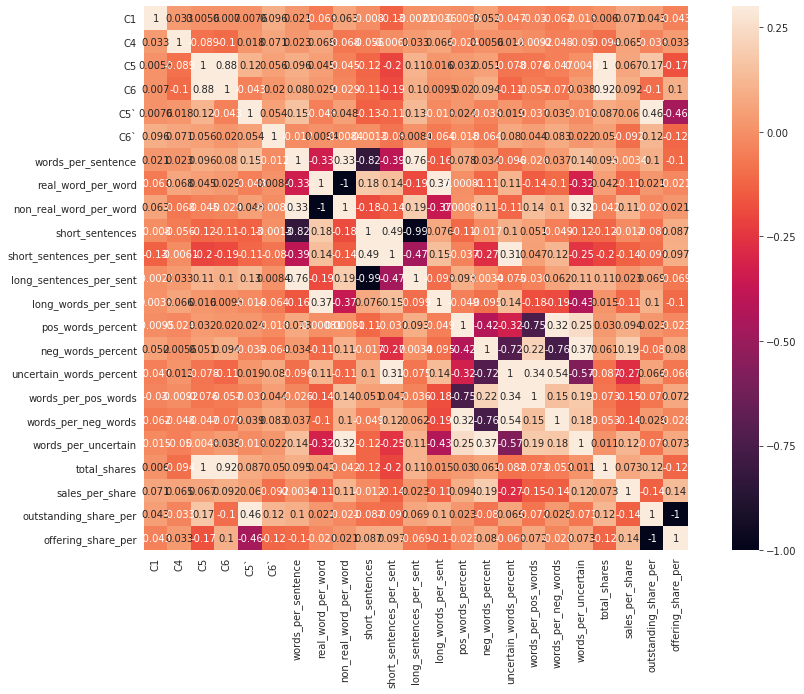

In [52]:
data_clean = pd.read_csv('ratios_done.csv', index_col=[0]) 
data_clean_cont = data_clean[['C1',
       'C4', 'C5', 'C6', 
         'C5`', 'C6`', 'words_per_sentence', 'real_word_per_word',
       'non_real_word_per_word', 'short_sentences', 'short_sentences_per_sent',
       'long_sentences_per_sent', 'long_words_per_sent', 'pos_words_percent',
       'neg_words_percent', 'uncertain_words_percent', 'words_per_pos_words',
       'words_per_neg_words', 'words_per_uncertain', 'total_shares',
       'sales_per_share', 'outstanding_share_per', 'offering_share_per']]
orig_corr = data_clean_cont.corr()

mask = np.zeros_like(orig_corr)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(orig_corr, mask=mask, vmax=.3, square=True,annot=True)

We expect the diagonal to be a perfect correlation as it represents one field against itself. We also see others which are potentially correlated and need to be addressed.

Some of these fields make intuitive sense as they were created off of the same input values. Initially both sets were retained as it was unknown which had the most predictive power. We can use this chart to pick subsets to be tested against each other later on.

# Pipeline A Correlation 
The following df contains features that went throgh the whole pipeline. Note that some features did need to be normalized. 

In [53]:
data1 = continous_standerdized[['C4_iqr_min_max',
       'C3_impute_iqr_min_max',
       'words_per_sentence_iqr_min_max',
       'long_sentences_per_sent_iqr_min_max',
       'long_words_per_sent_iqr_min_max', 'pos_words_percent_iqr_min_max',
       'neg_words_percent_iqr_min_max', 'uncertain_words_percent_iqr_min_max', 'words_per_neg_words_iqr_min_max',
       'words_per_uncertain_iqr_min_max', 'outstanding_share_per_iqr_min_max',
       'offering_share_per_iqr_min_max']]

continous_normalized = continous_normalized[['C5`_norm',
       'C6`_norm', 'short_sentences_norm', 'short_sent_per_sent_norm',
       'total_shares_norm', 'sales_per_share_norm', 'words_per_pos_words_norm',
       'real_word_per_word_norm', 'non_real_word_per_word_norm','C1_norm', 'C5_norm', 'C6_norm']]

data3 = pd.concat([data1, continous_normalized,data[['C2','C3`','div_services','div_manufacturing','div_other','Y1','Y2']]],axis=1)
data3.shape

(656, 31)

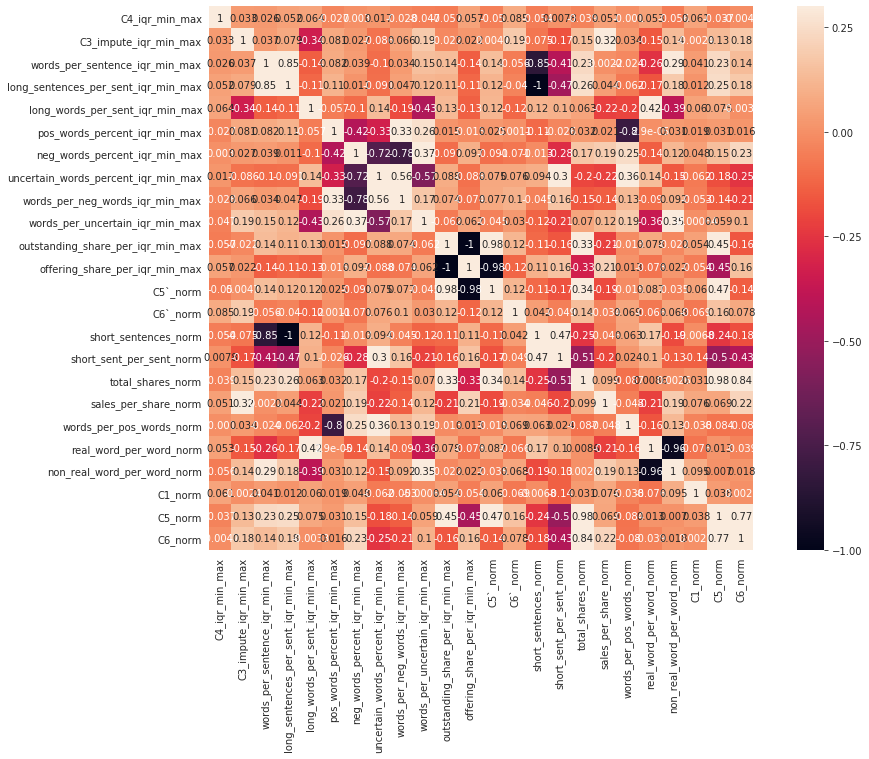

In [55]:
pipeline_a = data3.select_dtypes(include=['float64']).corr()

mask = np.zeros_like(orig_corr)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(pipeline_a, vmax=.3, square=True,annot=True)

In order to ensure that we identify highly correlated fields, we can keep track of all pairwise sets with a correlation value either below 0.5 or above 0.5 in their correlation values. 

In [56]:
# Create correlation matrix
corr_matrix = data3.select_dtypes(include=['float64']).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation smaller than 0.5
low_corr = [column for column in upper.columns if any(upper[column] < 0.5)]

This mapping can be used to ensure we are not leveraging correlated features once feature selection and modelling begins.

# Feature selection <a name="paragraph10"></a>
Back to [Table of Contents](#tablecontents)

Feature selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in. Having irrelevant features in your data can decrease the accuracy of the models and make your model learn based on irrelevant features.

We used the RFE paired with logistic regression. Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

Note that you do not need to check the performance (f1-score) or goodness-of-fit (AUC) in your model here since RFE automatically select the best subset of features. The next step is to test this features performance and then manualy add and removing to check model performance. RFE is like a black box - you can use a different method which you can look into the feature selection process, and have more control.

**NOTE:** Initially all fields were used for prediction if they were normalized, with the exception of the variations of C6 for Y1. This segmentation is necessary as C6 is formed off of the same fields used to create the target.

In [57]:
# Import your necessary dependencies
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

We have 23 features that have low correlation.

In [236]:
# lenght of columns 
len(data3[low_corr].columns)

23

In [237]:
# because we add 3 this will be different 
array = data3[low_corr].values
X = array #features
Y1 = data3.Y1.values #target 1
Y2 = data3.Y2.values #target 2

In [238]:
# check the shape of the features 
X.shape

(656, 23)

In [239]:
# check shape of target variabel Y1
Y1.shape

(656,)

In [240]:
# data is balanced
data3.Y1.value_counts()

1    328
0    328
Name: Y1, dtype: int64

In [241]:
# check shape of target variabel Y2
Y2.shape

(656,)

Data is not balanced for which we will account for in our model. 

In [242]:
# value counts
data3.Y2.value_counts()

0    497
1    159
Name: Y2, dtype: int64

Only test fields intented for final results (nothing used in other features created, nothing relating to target variable)

### Best features selected for Y1
Note there are no target variables when slecting features. We had to remove C6` as the calculation is too similar to Y1.

In [243]:
# remove C6` for Y1 feature selection 
X_y1 = data3[['C4_iqr_min_max', 'C3_impute_iqr_min_max',
       'words_per_sentence_iqr_min_max', 'long_sentences_per_sent_iqr_min_max',
       'long_words_per_sent_iqr_min_max', 'pos_words_percent_iqr_min_max',
       'neg_words_percent_iqr_min_max', 'uncertain_words_percent_iqr_min_max',
       'words_per_neg_words_iqr_min_max', 'words_per_uncertain_iqr_min_max',
       'outstanding_share_per_iqr_min_max', 'offering_share_per_iqr_min_max',
       'C5`_norm', 'short_sentences_norm',
       'short_sent_per_sent_norm', 'total_shares_norm', 'sales_per_share_norm',
       'words_per_pos_words_norm', 'real_word_per_word_norm',
       'non_real_word_per_word_norm', 'C1_norm', 'C5_norm', 'C6_norm', 'C2',
       'C3`', 'div_services', 'div_manufacturing', 'div_other']]
array_y1 = X_y1.values

In [244]:
# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression(random_state=123)
# create the RFE model and select 5 attributes
rfe = RFE(model, 7)
fit = rfe.fit(array_y1, Y1)
# summarize the selection of the attributes for Y1
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

# get column names 
mask = fit.get_support()
col_names = X_y1.columns
new_features_y1 = col_names[mask]
print('Feature names: ',new_features_y1)

Num Features: 7
Selected Features: [ True  True False  True False False False False  True False False False
 False False False False False  True False  True False  True False False
 False False False False]
Feature Ranking: [ 1  1  4  1  3 14  2  8  1 19 11  9 16  7 15 12 18  1 10  1  6  1 13  5
 20 17 21 22]
Feature names:  Index(['C4_iqr_min_max', 'C3_impute_iqr_min_max',
       'long_sentences_per_sent_iqr_min_max',
       'words_per_neg_words_iqr_min_max', 'words_per_pos_words_norm',
       'non_real_word_per_word_norm', 'C5_norm'],
      dtype='object')


### Best features selected for Y2

In [245]:
# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression(random_state=123)
# create the RFE model and select 5 attributes
rfe = RFE(model, 8)
fit = rfe.fit(X, Y2)
# summarize the selection of the attributes for Y1
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

# get column names 
mask = fit.get_support()
d = data3[low_corr].columns
new_features_y2 = d[mask]
new_features_y2

Num Features: 8
Selected Features: [False  True  True  True False False False  True False  True  True False
  True False False False False False False False False False  True]
Feature Ranking: [11  1  1  1 14 12 15  1  3  1  1 16  1  6  2 13  7  8  5  4 10  9  1]


Index(['words_per_sentence_iqr_min_max', 'long_sentences_per_sent_iqr_min_max',
       'long_words_per_sent_iqr_min_max', 'words_per_neg_words_iqr_min_max',
       'outstanding_share_per_iqr_min_max', 'offering_share_per_iqr_min_max',
       'C6`_norm', 'C6_norm'],
      dtype='object')

### Load the features in the model and experiment

In [246]:
y1 = data3.Y1
y2 = data3.Y2

# select features from our df for Y1
predictors_y1 = data3[new_features_y1]
# select features from our df for Y2
predictors_y2 = data3[new_features_y2]
# Y1 and Y2 already selected above as Y1, Y2 variables

# Modeling and Testing <a name="paragraph11"></a>
Back to [Table of Contents](#tablecontents)

### Logistic Regression Y1 

This is a logistic regression model that runs 10-times and calculates the average score. 

In [247]:
# lists for f1-score and AUC
f1_score_lst = []
auc_lst = []


#loop to calculate f1 and auc scores and present averages after 10 runs
for count in range (1,10):
    #Model building
    clf = LogisticRegression()
    X1_train, X1_test, y1_train, y1_test = train_test_split(predictors_y1, y1, test_size=0.2, random_state=123)
    clf.fit(X1_train, y1_train)

    y1_pred = clf.predict(X1_test)

    
    #10-fold cross validation
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(clf, X1_train, y1_train, cv=kfold, scoring=scoring)

    

    
    #calculate f1-score and AUC
    
    clf_roc_auc = roc_auc_score(y1_test, y1_pred)
    f1_score_lst.append(precision_recall_fscore_support(y1_test, y1_pred, average='weighted')[2])
    auc_lst.append(clf_roc_auc)


print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

#result=logit_model.fit()
confusion_matrix_y1 = confusion_matrix(y1_test, y1_pred)


#print(result.summary())
print('Accuracy of classifier on test set: {:.2f}'.format(clf.score(X1_test, y1_test)))

print("10-fold cross validation average accuracy of classifier: %.3f" % (results.mean()))

print('Confusion Matrix for Logistic Regression Classfier:')
print(confusion_matrix_y1)

print('Classification Report for Logistic Regression Classfier:')
print(classification_report(y1_test, y1_pred))

/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is Fal

F1 0.6520; AUC 0.6573 
Accuracy of classifier on test set: 0.65
10-fold cross validation average accuracy of classifier: 0.616
Confusion Matrix for Logistic Regression Classfier:
[[44 29]
 [17 42]]
Classification Report for Logistic Regression Classfier:
              precision    recall  f1-score   support

           0       0.72      0.60      0.66        73
           1       0.59      0.71      0.65        59

    accuracy                           0.65       132
   macro avg       0.66      0.66      0.65       132
weighted avg       0.66      0.65      0.65       132



/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


### Logistic regression Y2

In [248]:
# lists for f1-score and AUC
f1_score_lst = []
auc_lst = []


#loop to calculate f1 and auc scores and present averages after 10 runs
for count in range (1,10):
    #Model building
    clf1 = LogisticRegression()

    
    # Splitting data into testing and training
    X2_train, X2_test, y2_train, y2_test = train_test_split(predictors_y2, y2, test_size=0.2, random_state=123)
    
    # Begin oversampling
    oversample = pd.concat([X2_train,y2_train],axis=1)
    max_size = oversample['Y2'].value_counts().max()
    lst = [oversample]
    for class_index, group in oversample.groupby('Y2'):
        lst.append(group.sample(max_size-len(group), replace=True))
    X2_train = pd.concat(lst)
    y2_train=pd.DataFrame.copy(X2_train['Y2'])
    del X2_train['Y2']
    
    # fitting model on oversampled data
    clf1.fit(X2_train, y2_train)
    
    y2_pred = clf1.predict(X2_test)
    
    
    #10-fold cross validation
    kfold = model_selection.KFold(n_splits=10, random_state=123)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(clf1, X2_train, y2_train, cv=kfold, scoring=scoring)
    
    #calculate f1-score and AUC
    
    clf1_roc_auc = roc_auc_score(y2_test, y2_pred)
    
    
    #calculate average f1-score and AUC
    f1_score_lst.append(precision_recall_fscore_support(y2_test, y2_pred, average='weighted')[2])
    auc_lst.append(clf1_roc_auc)
    
    
print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

confusion_matrix_y2 = confusion_matrix(y2_test, y2_pred)


print('Accuracy of classifier on test set: {:.3f}'.format(clf1.score(X2_test, y2_test)))

print("10-fold cross validation average accuracy of clf1: %.3f" % (results.mean()))

print('Confusion Matrix for Classfier:')
print(confusion_matrix_y2)

print('Classification Report for Classfier:')
print(classification_report(y2_test, y2_pred))



/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is Fal

F1 0.5789; AUC 0.5720 
Accuracy of classifier on test set: 0.530
10-fold cross validation average accuracy of clf1: 0.532
Confusion Matrix for Classfier:
[[53 53]
 [ 9 17]]
Classification Report for Classfier:
              precision    recall  f1-score   support

           0       0.85      0.50      0.63       106
           1       0.24      0.65      0.35        26

    accuracy                           0.53       132
   macro avg       0.55      0.58      0.49       132
weighted avg       0.73      0.53      0.58       132



# Results and future work <a name="paragraph12"></a>
Back to [Table of Contents](#tablecontents)

Due to time constraints we feature selection was only ran thorugh features with low correlation that includes 23 features. As we have 124 features at our displosal results we believe results can be significanlty improved. The most relevent features were as follows:<br>


**Y1:** <span style="color:red">['C4_iqr_min_max',<br>
    'C3_impute_iqr_min_max',<br>
    'long_sentences_per_sent_iqr_min_max',<br>
    'words_per_neg_words_iqr_min_max',<br>
    'words_per_pos_words_norm',<br>
    'non_real_word_per_word_norm',<br>
    'C5_norm ]<br></span>

After running the evaluation code, Y1 resulted in a promising score of F1 0.6520; AUC 0.6573.

**Y2:** <span style="color:red">'words_per_sentence_iqr_min_max',<br>
    'long_sentences_per_sent_iqr_min_max',<br>
       'long_words_per_sent_iqr_min_max', <br>
    'words_per_neg_words_iqr_min_max',<br>
       'outstanding_share_per_iqr_min_max',<br>
    'offering_share_per_iqr_min_max',<br>
       'C6`_norm', 'C6_norm'<br></span>

After running the evaluation code, Y2 resulted in a score of F1 0.5789; AUC 0.5720.

We can say that with 57% - 65% degree of certanty when the IPO is going to be underpriced.  
 

**Reasonging:** As we see from our features the supply and demand of stocks and sentiment is a big factor. An extreme example would be Tesla. It is a highly volatile stock which almost went bankrupt in 2008, however, Elon Musk's pre-IPO marketing and brand awareness made a big difference and created a high demand for the stock. Moreover, sentiment analysis features (positive, negative words...) we retrieved from SEC were also important in the analysis. However, this only informs a small percentage of people as not everyone reads the prospectus. It would be interesting to include public sentiment/demand for the stock and judge whether the IPO is underpriced. 

### Recomendations and Future Work
- Build pipeline and merge data and use that data for feature selection and testing 
- Try different models such as XGBoost and random forest  
- Add more sentimental analysis features 
    - we believe that they have a big impact on whether the IPO is going to be under priced. For instance, twitter, and news activity. If the company has the exposure there is more chance of people buying the stock. The more excitement is behind, the more chance there is that the price will jump and then even more after the general public is doing well. 